In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import scipy.io as sio
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [ ]:
# Set directory containing fig_data folder
data_dir = ""

In [ ]:


# Load plot configuration from your existing file if available
try:
    from examples.paper_figures.plot_config import params, contourLevels, colormap, savefig_format, SMALL_SIZE
    plt.rcParams.update(params)
except ImportError:
    # Default settings if plot_config not available
    SMALL_SIZE = 6
    MEDIUM_SIZE = 7
    BIGGER_SIZE = 8
    
    plt.rcParams.update({
        'font.size': SMALL_SIZE,
        'axes.titlesize': BIGGER_SIZE,
        'axes.labelsize': MEDIUM_SIZE,
        'xtick.labelsize': SMALL_SIZE,
        'ytick.labelsize': SMALL_SIZE,
        'legend.fontsize': SMALL_SIZE,
        'figure.titlesize': BIGGER_SIZE
    })

# Plotting parameters from your existing code
polygon_col = np.array([49, 130, 189]) / 256
map_col = 0.3*np.array([1, 1, 1])
map_lw = 0.5
polygon_lw = 1
tick_length = 2.5
tick_width = 0.5
label_fontsize = 5
panel_linewidth = 0.5

# Define Core Monsoon Zone polygon
polygon1_lon = np.array([86, 74, 74, 70, 70, 82, 82, 86, 86])
polygon1_lat = np.array([18, 18, 22, 22, 30, 30, 26, 26, 18])

def get_india_outline():
    """
    Get India outline coordinates. First try to load from shapefile, 
    then fall back to simplified coordinates.
    """
    try:
        # Try to load India shapefile
        shapefile_paths = [
            f'{data_dir}/fig_data/ind_map_shapefile/india_shapefile.shp',
            'india_shapefile.shp'
        ]
        
        for path in shapefile_paths:
            try:
                import geopandas as gpd
                india_gdf = gpd.read_file(path)
                boundaries = []
                for geom in india_gdf.geometry:
                    if hasattr(geom, 'exterior'):
                        coords = list(geom.exterior.coords)
                        lon_coords = [coord[0] for coord in coords]
                        lat_coords = [coord[1] for coord in coords]
                        boundaries.append((lon_coords, lat_coords))
                    elif hasattr(geom, 'geoms'):
                        for sub_geom in geom.geoms:
                            if hasattr(sub_geom, 'exterior'):
                                coords = list(sub_geom.exterior.coords)
                                lon_coords = [coord[0] for coord in coords]
                                lat_coords = [coord[1] for coord in coords]
                                boundaries.append((lon_coords, lat_coords))
                return boundaries
            except:
                continue
    except:
        pass
    
    # Fallback to simplified India outline
    india_lon = np.array([68, 97, 97, 68, 68])
    india_lat = np.array([8, 8, 37, 37, 8])
    return [(india_lon, india_lat)]

def doy_to_date_string(doy):
    """Convert day of year to dd/mm format"""
    # Assuming non-leap year for consistency
    date = datetime(2023, 1, 1) + timedelta(days=int(doy) - 1)
    return date.strftime('%d/%m')

print("Functions defined successfully")

Functions defined successfully


In [10]:
# Load data from your MAT file
mat_file_path = f"{data_dir}/fig_data/onset_thres_clim_onset.mat"

try:
    # Load the MAT file
    data = sio.loadmat(mat_file_path)
    
    print("Available variables in MAT file:", [key for key in data.keys() if not key.startswith('__')])
    
    # Extract the required variables
    lon = data['lon'].flatten()
    lat = data['lat'].flatten()
    onset_day_thres = data['onset_day_thres']
    clim_onset_doy = data['clim_onset_doy']
    
    print(f"Data loaded successfully!")
    print(f"Longitude range: {lon.min():.2f} to {lon.max():.2f}")
    print(f"Latitude range: {lat.min():.2f} to {lat.max():.2f}")
    print(f"Onset threshold shape: {onset_day_thres.shape}")
    print(f"Onset threshold range: {np.nanmin(onset_day_thres):.2f} to {np.nanmax(onset_day_thres):.2f}")
    print(f"Climatological onset DOY shape: {clim_onset_doy.shape}")
    print(f"Climatological onset DOY range: {np.nanmin(clim_onset_doy):.1f} to {np.nanmax(clim_onset_doy):.1f}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please check the file path and variable names in your MAT file")

Available variables in MAT file: ['clim_onset_doy', 'lat', 'lon', 'onset_day_thres']
Data loaded successfully!
Longitude range: 68.00 to 100.00
Latitude range: 8.00 to 36.00
Onset threshold shape: (9, 8)
Onset threshold range: 12.91 to 100.97
Climatological onset DOY shape: (9, 8)
Climatological onset DOY range: 157.3 to 223.2


In [11]:
SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 8
LARGE_SIZE = 8
def create_onset_panel(ax, data, lon, lat, title, cmap_name='viridis', vmin=None, vmax=None, 
                      show_ylabel=True, is_threshold=True):
    """
    Create a map panel for onset data
    """
    # Create meshgrid for plotting
    lon_edges = np.concatenate([lon - (lon[1]-lon[0])/2, [lon[-1] + (lon[1]-lon[0])/2]])
    lat_edges = np.concatenate([lat - (lat[1]-lat[0])/2, [lat[-1] + (lat[1]-lat[0])/2]])
    LON_edges, LAT_edges = np.meshgrid(lon_edges, lat_edges)
    
    # Mask invalid data
    masked_data = np.ma.masked_invalid(data.T)
    
    # Set colormap and limits
    if vmin is None:
        vmin = np.nanmin(data)
    if vmax is None:
        vmax = np.nanmax(data)
    
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Plot the data
    im = ax.pcolormesh(LON_edges, LAT_edges, masked_data, 
                       cmap=cmap, vmin=vmin, vmax=vmax, shading='flat')
    
    # Add India map outline
    india_boundaries = get_india_outline()
    for boundary in india_boundaries:
        india_lon, india_lat = boundary
        ax.plot(india_lon, india_lat, color='black', linewidth=map_lw)
    
    # # Add polygon for Core Monsoon Zone
    # polygon = Polygon(list(zip(polygon1_lon, polygon1_lat)), 
    #                  fill=False, edgecolor='black', linewidth=polygon_lw)
    # ax.add_patch(polygon)
    
    # Add grid values as text
    for i, lon_val in enumerate(lon):
        for j, lat_val in enumerate(lat):
            if not np.isnan(data[i, j]):
                value = data[i, j]
                if is_threshold:
                    # For threshold data, show as integer mm
                    text_val = f'{int(value)}'
                    color = 'white' if value > (vmax - vmin) * 0.7 + vmin else 'black'
                # else:
                #     # For onset date, show as dd/mm
                #     text_val = doy_to_date_string(value)
                #     color = 'white' if value > (vmax - vmin) * 0.7 + vmin else 'black'
                
                # ax.text(lon_val, lat_val, text_val,
                #        ha='center', va='center',
                #        color=color, fontsize=SMALL_SIZE)
    
    # Set axis limits and ticks
    ax.set_xlim([lon[0]-4, 100])
    ax.set_ylim([lat[0]-4, lat[-1]+4])
    
    # Create tick labels
    yticks = np.arange(lat[0]-2, lat[-1]+3, 8)
    yticklabels = [f"{int(y)}°N" if i % 1 == 0 else "" for i, y in enumerate(yticks)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    
    
    xticks = np.arange(lon[0]-2, lon[-1]+3, 8)
    xticklabels = [f"{int(x)}°E" if i % 1 == 0 else "" for i, x in enumerate(xticks)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    # Remove grid lines
    ax.grid(False)
    ax.set_axisbelow(False)
    ax.tick_params('both', length=tick_length, width=tick_width, which='major')
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='y', which='minor', left=False, right=False)

    # Add title
    ax.text(0.5, 1.02, title, transform=ax.transAxes, horizontalalignment='center',
            verticalalignment='bottom', fontsize=LARGE_SIZE, fontweight='normal')

    return im



Creating onset figure...
Creating threshold panel...
Creating onset date panel...


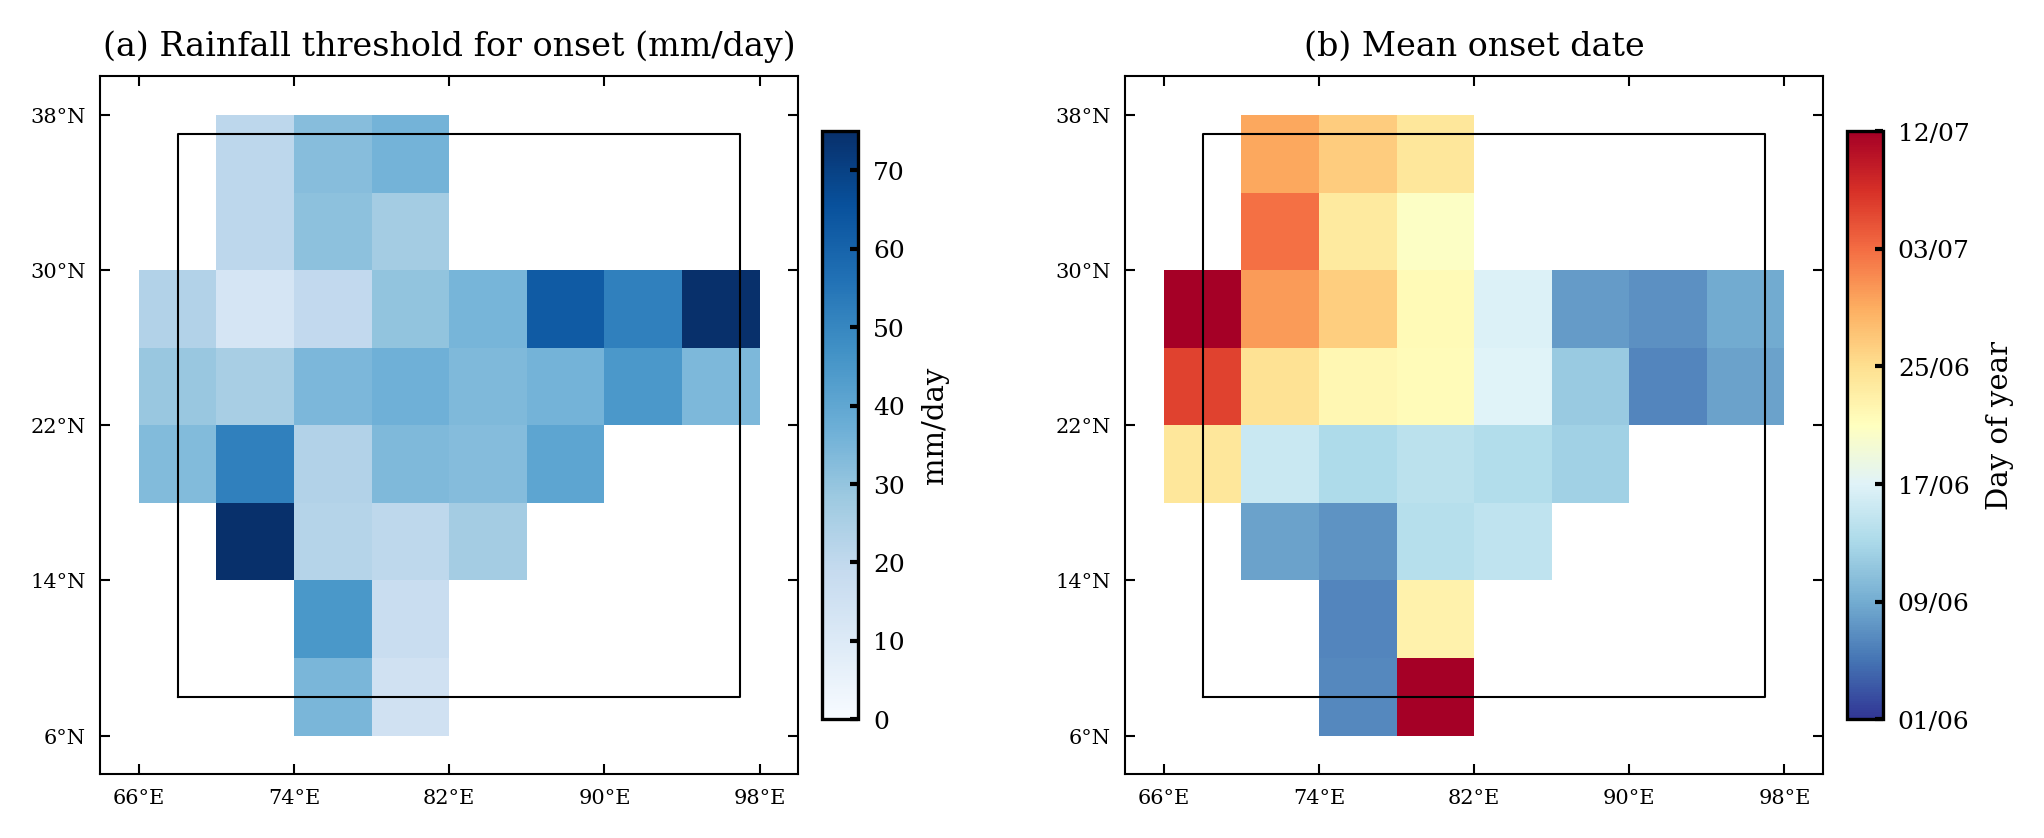

Figure created successfully!
Onset plotting functions created successfully!


In [12]:
def create_onset_figure():
    """Create the complete two-panel figure for onset threshold and climatological onset"""
    
    # Create the main figure
    fig = plt.figure(figsize=(8, 4), dpi=300)
    
    # Create GridSpec - adjusted to accommodate colorbars on the right
    gs = GridSpec(
        1, 14, figure=fig,
        hspace=0.1, wspace=0.3,
        left=0.08, right=0.92, top=0.85, bottom=0.15
    )

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0:5])   # Threshold panel
    ax2 = fig.add_subplot(gs[0, 7:12])  # Onset date panel (shifted to leave space for colorbar)
    
    print("Creating threshold panel...")
    # Panel 1: Rainfall threshold
    im1 = create_onset_panel(ax1, onset_day_thres, lon, lat, 
                            "(a) Rainfall threshold for onset (mm/day)",
                            cmap_name='Blues', vmin=0, vmax=75,
                            show_ylabel=True, is_threshold=True)
    
    print("Creating onset date panel...")
    # Panel 2: Climatological onset date
    im2 = create_onset_panel(ax2, clim_onset_doy, lon, lat,
                            "(b) Mean onset date",
                            cmap_name='RdYlBu_r', 
                            vmin=152, 
                            vmax=193,
                            show_ylabel=False, is_threshold=False)
    
    # Get panel positions for colorbar placement
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    
    # Create colorbars on the right side of each panel
    # Colorbar height = EXACTLY 75% of panel height
    colorbar_height = pos1.height * 0.7  # 75% of panel height
    colorbar_width = 0.015
    
    # Calculate vertical offset to center the colorbar
    vertical_offset = (pos1.height - colorbar_height) / 2
    
    # Threshold colorbar (right of panel 1)
    cax1 = fig.add_axes([
        pos1.x1 + 0.01,  # x position (right of panel 1)
        pos1.y0 + vertical_offset,  # y position (centered vertically with 75% height)
        colorbar_width,  # width
        colorbar_height  # height (EXACTLY 75% of panel height)
    ])
    
    cbar1 = fig.colorbar(im1, cax=cax1, orientation='vertical')
    cbar1.set_label('mm/day', fontsize=MEDIUM_SIZE)
    cbar1.ax.tick_params(labelsize=SMALL_SIZE, length=2, width=1)
    cbar1.ax.minorticks_off()
    
    # Onset date colorbar (right of panel 2)
    # Use the same calculation for panel 2
    colorbar_height_2 = pos2.height * 0.7  # 75% of panel 2 height
    vertical_offset_2 = (pos2.height - colorbar_height_2) / 2
    
    cax2 = fig.add_axes([
        pos2.x1 + 0.01,  # x position (right of panel 2)
        pos2.y0 + vertical_offset_2,  # y position (centered vertically with 75% height)
        colorbar_width,  # width
        colorbar_height_2  # height (EXACTLY 75% of panel height)
    ])
    
    cbar2 = fig.colorbar(im2, cax=cax2, orientation='vertical')
    cbar2.set_label('Day of year', fontsize=MEDIUM_SIZE)
    cbar2.ax.tick_params(labelsize=SMALL_SIZE, length=2, width=1)
    cbar2.ax.minorticks_off()
    
    # Add some representative date labels to the onset colorbar
    # Set color axis range [152, 193] and convert to dates
    tick_positions = np.linspace(152, 193, 6)  # 6 ticks for better spacing
    tick_labels = [doy_to_date_string(pos) for pos in tick_positions]
    cbar2.set_ticks(tick_positions)
    cbar2.set_ticklabels(tick_labels)
    
    # Styling
    map_axes = [ax1, ax2]
    for ax in map_axes:
        ax.tick_params(axis='both', which='major', labelsize=label_fontsize, 
                      length=tick_length, width=tick_width)
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_linewidth(panel_linewidth)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(False)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('fig15.pdf', dpi=600, bbox_inches='tight')
    return fig

# Create the figure if data is loaded
if 'onset_day_thres' in locals() and 'clim_onset_doy' in locals():
    print("Creating onset figure...")
    onset_fig = create_onset_figure()
    plt.show()
    print("Figure created successfully!")
else:
    print("Please load the data first by running the data loading cell above.")

print("Onset plotting functions created successfully!")